# Case Study: Predict Customer Churn Using Machine Learning: Descriptive and Diagnostic Analytics

(from Michelle Bonat, IBM)

## 1: Frame the Problem

## **Case Study Overview**

Many companies would benefit immensely by investigating their customer churn and taking steps to improve it. Why? Simply stated, it usually takes much less resources to keep a customer than to get a new one. So if you have the information you need on why customers are leaving (churning) you can use this proactively to reduce your churn. Let's look at how we can develop this intelligence using machine learning.

----
##About The Data and The Approach

We're told by our colleagues at the hypothetical company that customer churn is at 50% within 3 months. That means that within 3 months of a set of customers that sign up for the paid product, by the end of 3 months half of them will have cancelled. This is an urgent problem we need to help fix with machine learning!

## - Dataset:
For this dataset I used an IBM Sample Dataset for customer churn from the TelCo industry which can be found [here](https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv)


## - Project Steps:

1. **Talk with stakeholders (S/H) to: **
  * **Discuss/determine goals and metrics for the project.**  Is reducing churn the right problem to solve? How specifically shall we measure performance improvement? What is our success goal? (Assume here: it is the right problem, we measure performance overall by reducing customer churn, success is reducing customer churn by 10% in next 6 months).
  * **Understand what deliverables are useful for internal stakeholders** (Assume it is churn prediction factors, later a spreadsheet of customer churn predictions, production pipeline and perhaps an internal dashboard).
  * **Discuss an iterative approach with timing and deliverables**, at a high level. First see if the data is predictive. Set a goal for what predictive means (Assume here: 80% +). Come back with findings in 2 weeks.
2. **Work with SME's (Subject Matter Experts) to come up with a hypothesis.** Here we'll assume that tenure, addt'l products/features, tech support interactions are key; also possibly how they pay.
3. **Get the data.** Work with data engineering to get the data, if needed.
3. **Talk to my team and resource the project.** Include team personal skills development where possible. In this case for example purposes, assume all the team is booked and I'll do the initial analysis which appears here.
3. **Prototype some approaches.** Is the data usable? Can churn be reliably predicted? Do we need other data? Can it eventually be done at scale?
4. **When a valid prototype is achieved, begin A/B testing.** If the prototype indicates a workable approach is viable, coordinate with S/H and team on next steps. Put A/B testing in place.
5. **Iterate data and models learned from A/B testing and internal model testing.** Get to target success metrics on prediction rate and any other target metrics in order to move forward.
6. **Create the production pipeline. **Once an initial model prototype has been established that surpasses the desired performance thresholds, it is ready for the production line.
  * Start simple with incremental wins. Expland as it makes sense with priorities and resources.
    * Load the flagged users (potential churners) back to the database as a first step
    * Eventually, move to automated data injection from a data warehouse
    * Refine the model and the data
    * Report performance to stakeholders and team on an ongiong basis. Get feedback and discuss next steps. Implement, learn, improve, repeat.
7. **Suggest some ways to improve churn in products and processes based on learnings from the activities listed above.**
    * These notes are listed at the bottom of this notebook.






## 2: Data we would we like to have:

Generally speaking we would like to have as much data as possible with a long history over as many categories as possible.

Here are some types of data that are useful in customer churn analysis:
* Customer ID or other identification information
* Date the customer was acquired
* How the customer was acquired (source of sale i.e. referral, web signup, etc.)
* Plan type (what subscription they are on)
* Cohort analysis by user type (seasonal onboards by marketing campaign or time of year, etc.)
* If they use add ons (sush as Online Security or Device Protection)?
* Have they set up to pay for their subscription online?
* Customer size
* Customer segment type (i.e. company user, accountant)
* Customer country of residence
* Customer state of residence
* NPS score (satisfaction level 0-10 from questionnaire)
* Time to first success moment (days)
* Total number of times logged in
* Time since last login
* Days since key inflection points (work with SME in marketing/product) this could be days since logging in, since getting their first result from the technology, etc.
* Time spent logged in past month
* Time spent logged in average/mo for length of subscription
* Number of times they have contacted customer service over life of subscription
* Number of customer service calls in the prior month that they cancelled
* Number of times they opened and clicked on the Help text in the app or online
* What they typed into the search box in the help text in the app
* Tenure (Lifetime account duration in days)
* Total subscription amount paid
* Date unsubscribed (timestamp)
* How many other products they have from our company
* What other products they have from our company, as a separate column for each (yes / no)
* Anything else specific to the business of note
* Cancelled yes or no (Churn)

## 3: SetUp: Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from sklearn import model_selection, metrics  #to include metrics for evaluation # this used to be cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Quiet warnings since this is a demo (it quiets future and deprecation warnings).
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 4: Access Data and Clean It Up

We're using the IBM Telco sample dataset for this case study. It provides some of the datapoints from our wish list but not all.

I staged the IBM sample dataset on my own S3 bucket on AWS and I'm accessing it from there:

In [4]:
# Read the data and view the top portion to see what we are dealing with.
data=pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.to_csv('telco_customer_churn.csv', index=False) #write the file - you can use this later
#you can use the files menu, refresh, and select the dots to download the file

In [ ]:
# See if the data is usable.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Analyze if there is non-numeric data in the 'TotalCharges' column since it's showing as an object instead of float64.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors = 'coerce')
data.loc[data['TotalCharges'].isna()==True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [ ]:
# Above we see that the blank "TotalCharges" happen when customers have 0 months tenure so we will change those values to $0.
data[data['TotalCharges'].isna()==True] = 0
data['OnlineBackup'].unique()

array(['Yes', 'No', 'No internet service', 0], dtype=object)

In [ ]:
# See how many rows and columns.
data.shape

(7043, 21)

More data cleanup: next we’ll convert the categorical values into numeric values.

In [ ]:
data['gender'].replace(['Male','Female'],[0,1],inplace=True)
data['Partner'].replace(['Yes','No'],[1,0],inplace=True)
data['Dependents'].replace(['Yes','No'],[1,0],inplace=True)
data['PhoneService'].replace(['Yes','No'],[1,0],inplace=True)
data['MultipleLines'].replace(['No phone service','No', 'Yes'],[0,0,1],inplace=True)
data['InternetService'].replace(['No','DSL','Fiber optic'],[0,1,2],inplace=True)
data['OnlineSecurity'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['OnlineBackup'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['DeviceProtection'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['TechSupport'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['StreamingTV'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['StreamingMovies'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['Contract'].replace(['Month-to-month', 'One year', 'Two year'],[0,1,2],inplace=True)
data['PaperlessBilling'].replace(['Yes','No'],[1,0],inplace=True)
data['PaymentMethod'].replace(['Electronic check', 'Mailed check', 'Bank transfer (automatic)','Credit card (automatic)'],[0,1,2,3],inplace=True)
data['Churn'].replace(['Yes','No'],[1,0],inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


Let's look at relationships between customer data and churn using correlation.

In [ ]:
datahm = data.select_dtypes(include='number').corr()

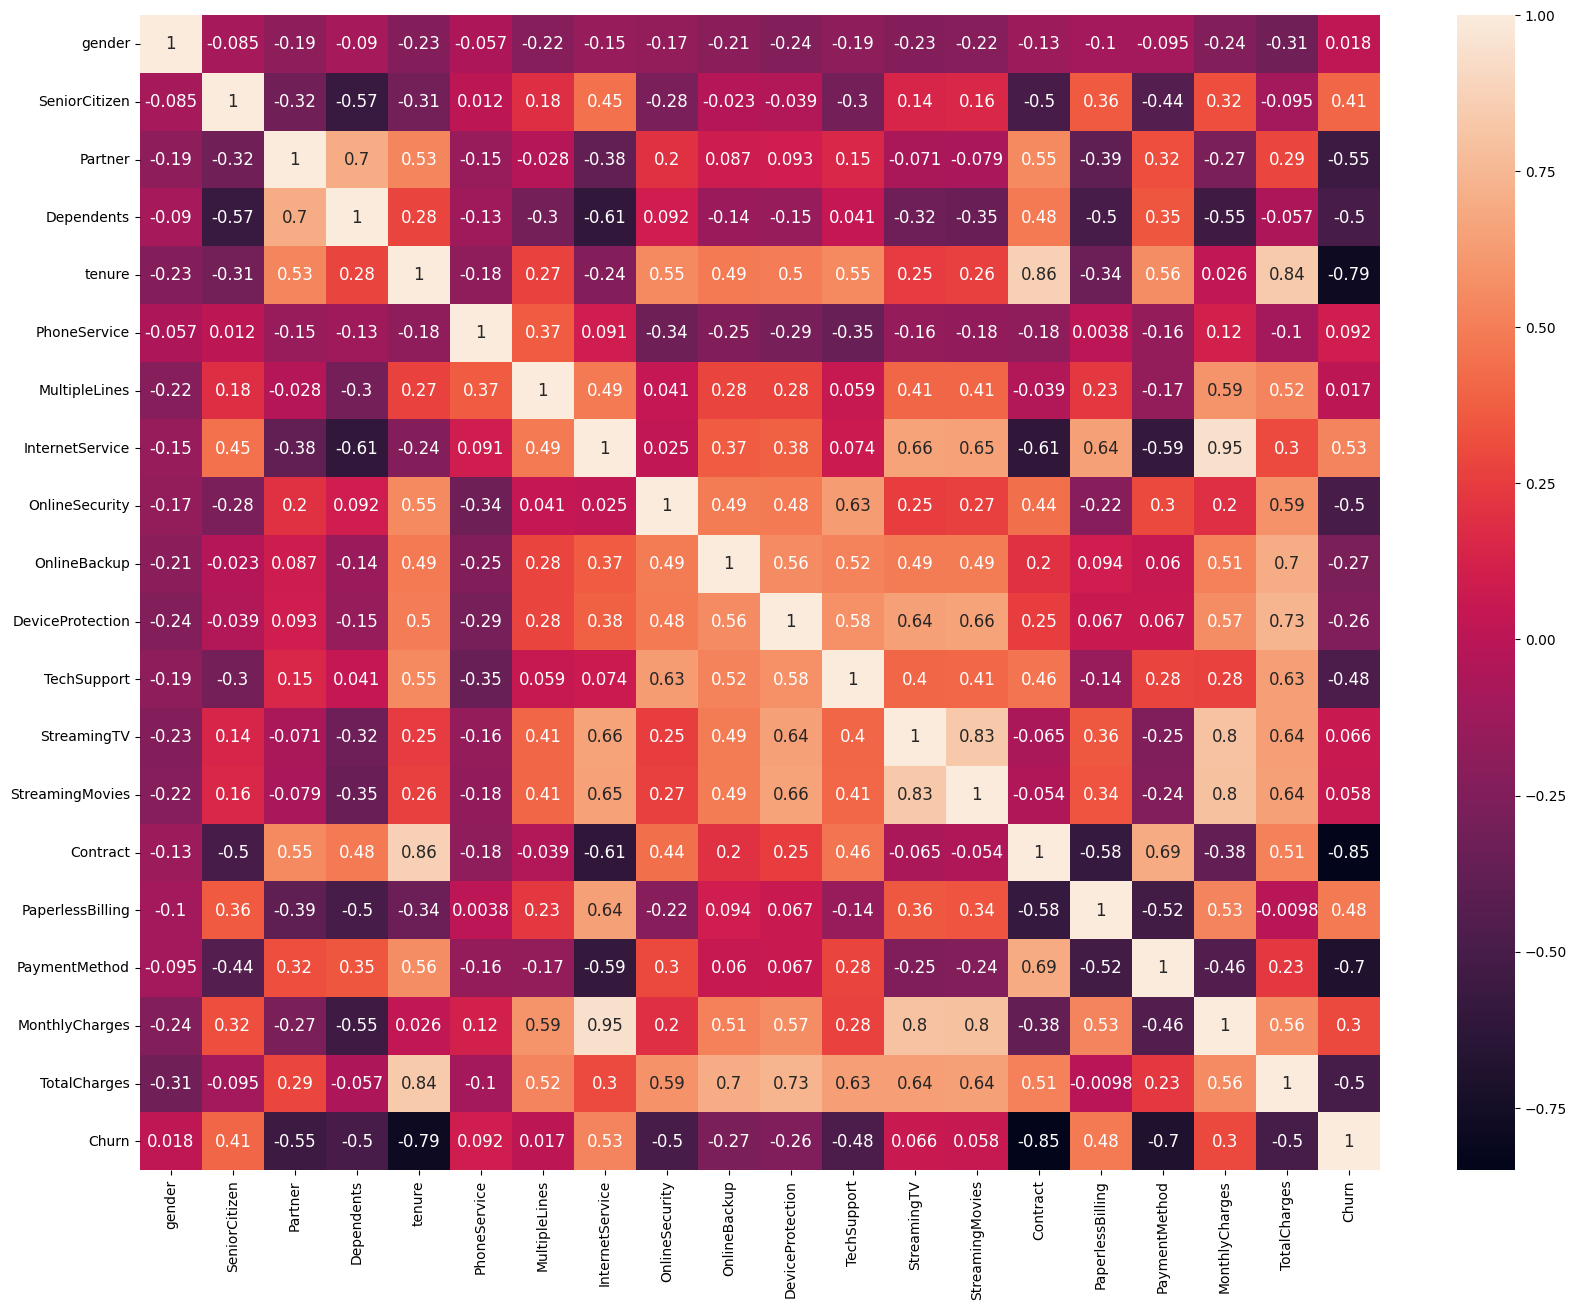

In [ ]:
corr = datahm.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Our goal is to avoid multicollinearity by dropping features that are closely correlated with each other. For example here it is TotalCharges and MonthlyCharges. So we will drop TotalCharges.

In [ ]:
data = data.drop('TotalCharges', axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


## 5: Explore The Data

In [ ]:
# Explore how many churn data points we have.
print(len(data['Churn']))

7043


In [ ]:
# Explore how many customers in this dataset have churned. Is this dataset 50% as the team suggests is the overall customer churn rate?
data['Churn'].value_counts()
# We see this dataset actually has less than the overall 50% churn rate of the entire company reported data (it's actually 26.54% that have churned.

,count
Churn,
0,5174
1,1869


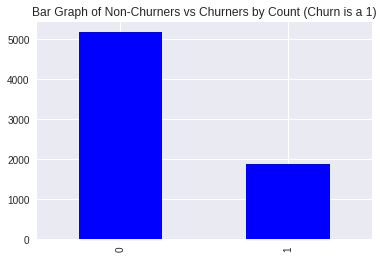

In [ ]:
# This creates a bar graph of churn (Yes vs. No) so we can check how the data is balanced.
data['Churn'].value_counts().plot(kind = 'bar', title = 'Bar Graph of Non-Churners vs Churners by Count (Churn is a 1)', color = 'blue', align = 'center')
plt.show()
# The dataset does not have a huge imbalance which is good news! But also we clearly see it does not have the 50% as we would have thought.

Explore some contingencies on how some features relate to churn.

In [ ]:
# Creates initial contingency table between Churn and gender. Male is 0, Female is 1.
gender_churn_contingency = pd.crosstab(data["gender"], data["Churn"])
display(gender_churn_contingency)
# Male and females churn at about the same rate, so not much to see here. Let's keep moving.

Churn,0,1
gender,,
0,2630,930
1,2544,939


<Axes: >

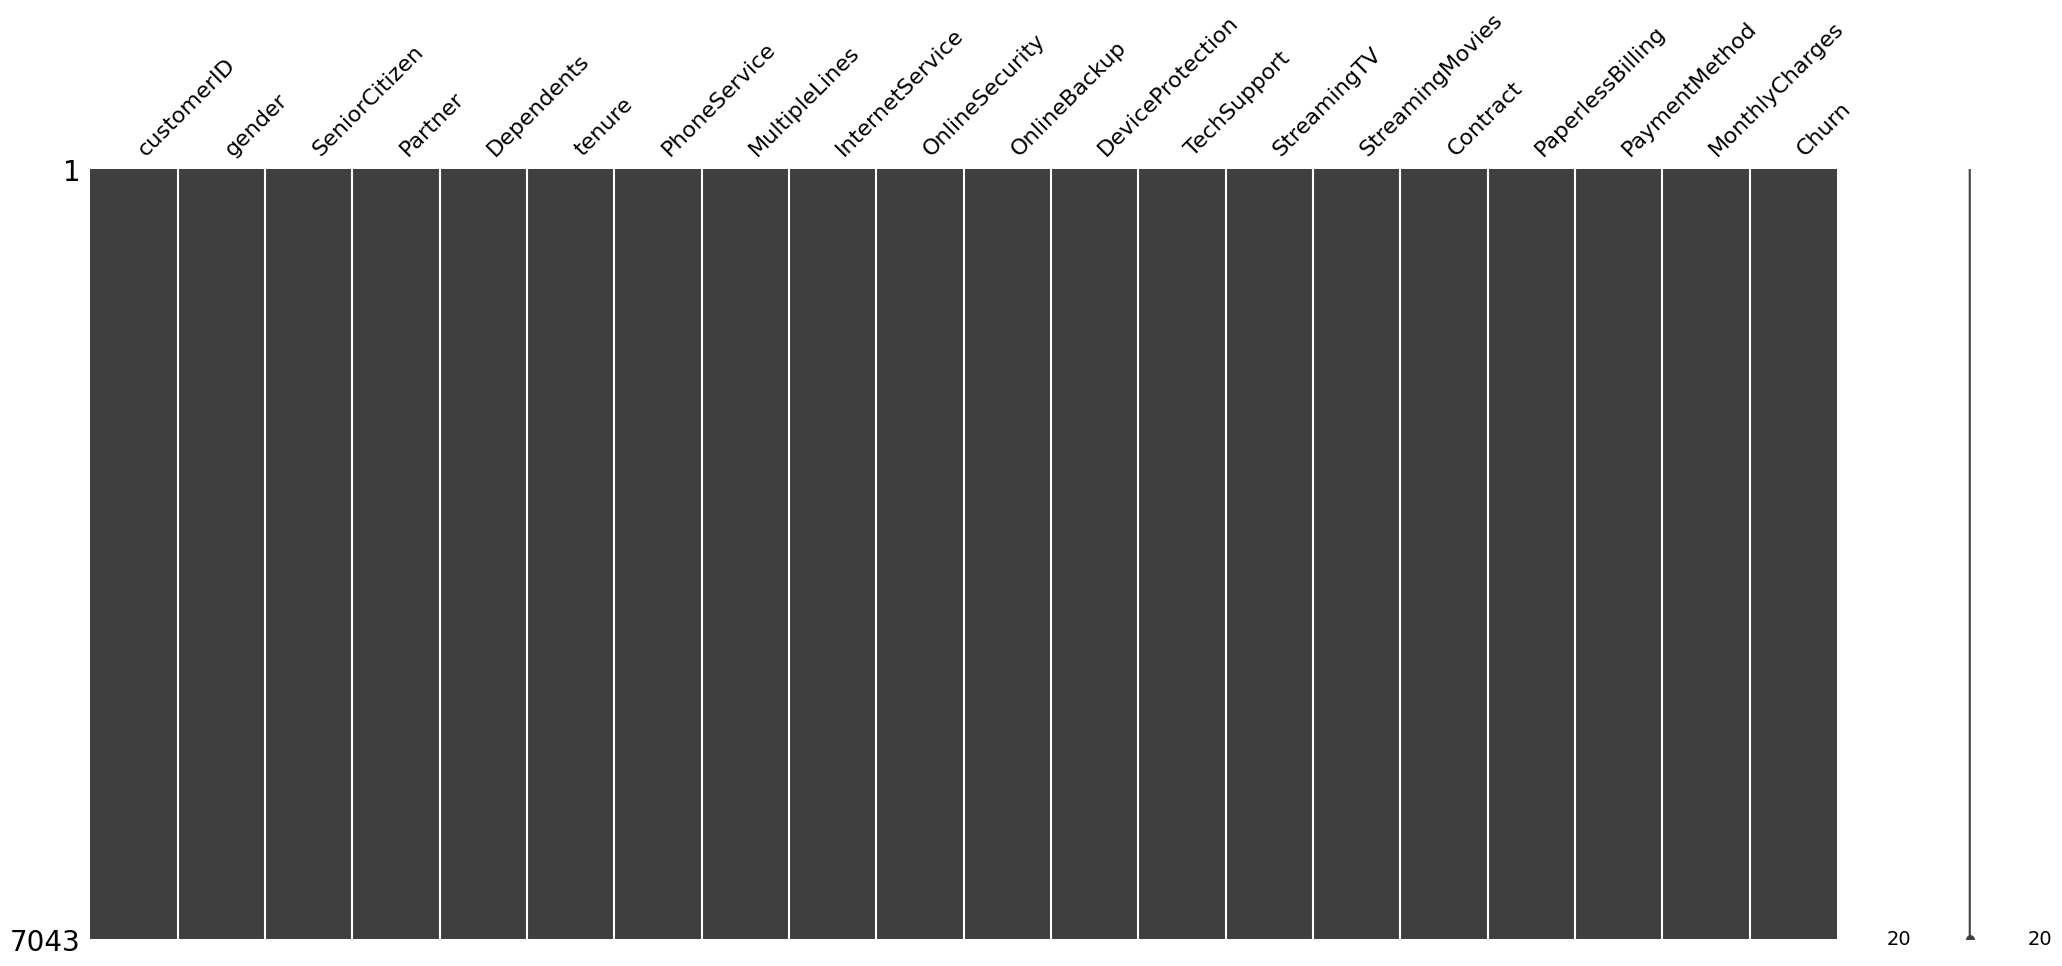

In [ ]:
# Check the data health. The sections should all be completely black indicating the data is complete.
ms.matrix(data)
# It looks good.

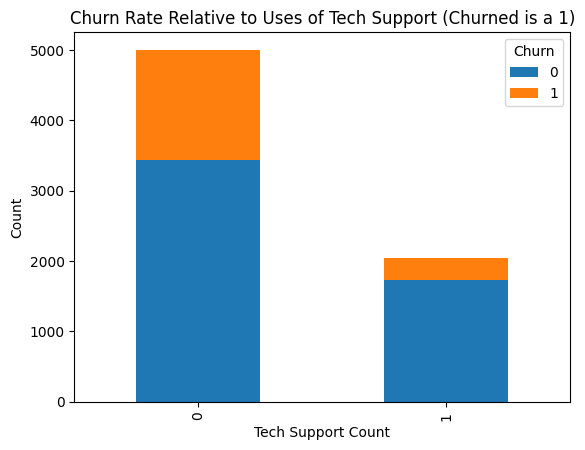

In [ ]:
# Explore the relationship between instances of Tech Support and Churn.
# Stacked Bar of Tech Support and Churn.
tech_support_churn = pd.crosstab(data['TechSupport'], data['Churn'])
tech_support_churn.plot(kind = 'bar', stacked = True)
plt.ylabel('Count')
plt.xlabel('Tech Support Count')
plt.title('Churn Rate Relative to Uses of Tech Support (Churned is a 1)')
plt.show()
# We can see that non-churners use tech support more often than customers that end up churning.
# So let's explore some ways to get people to use Tech Support more often so they cancel (churn) less. You can see notes for this at the bottom.
# Also, tech support in this data is just a Y/N. It would be useful in future to include how many tech support calls by customer so we could analyze how the number of tech support calls relates to churn.

<Figure size 1800x1000 with 0 Axes>

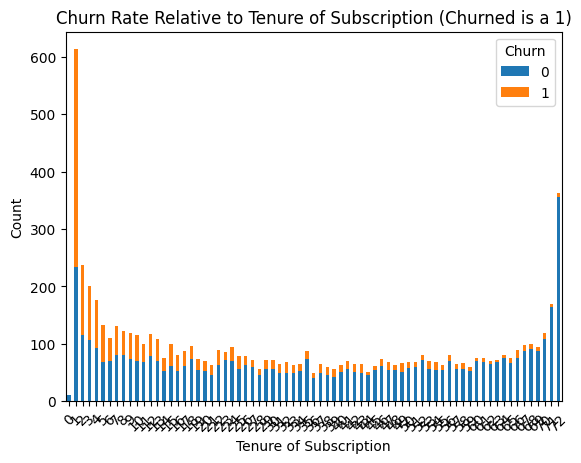

In [ ]:
# Churn rate relative to tenure.
# Stacked bar of tenure and churn.
plt.figure(figsize=(18, 10))
tenure_churn = pd.crosstab(data['tenure'], data['Churn'])
tenure_churn.plot(kind = 'bar', stacked = True)
plt.ylabel('Count')
plt.xlabel('Tenure of Subscription')
plt.title('Churn Rate Relative to Tenure of Subscription (Churned is a 1)')
plt.xticks(rotation=45)

plt.show()
# We can clearly see the longer a customer stays as a subscriber, the less they are likely to churn!

In [ ]:
# Distribution of features.
features = ['gender', 'SeniorCitizen','Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']
data[features].describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.494534,0.162147,0.481755,0.298026,32.371149,0.901888,0.421269,1.222206,0.286100,0.344314,0.343320,0.289649,0.383785,0.387761,0.687491,0.591793,1.313503,64.697004
std,0.500006,0.368612,0.499702,0.457424,24.559481,0.297487,0.493798,0.779535,0.451969,0.475178,0.474851,0.453632,0.486341,0.487274,0.832727,0.491537,1.149799,30.171186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.450000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,70.350000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,89.850000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,118.750000


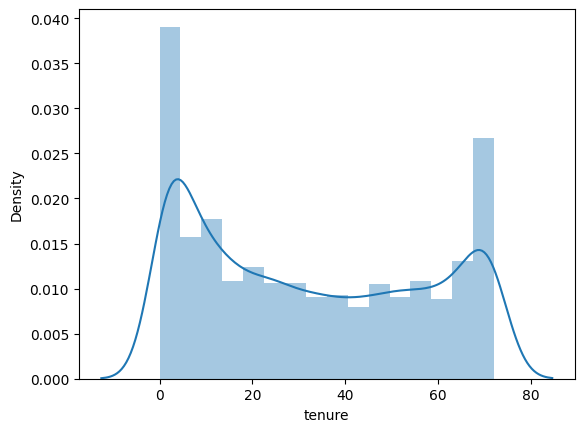

In [ ]:
# Plot the distribution of observations for tenure.
sns.distplot(data['tenure']);
# It shows the max tenure is 70. This must be when the data history ends. We'll account for this in our analysis.

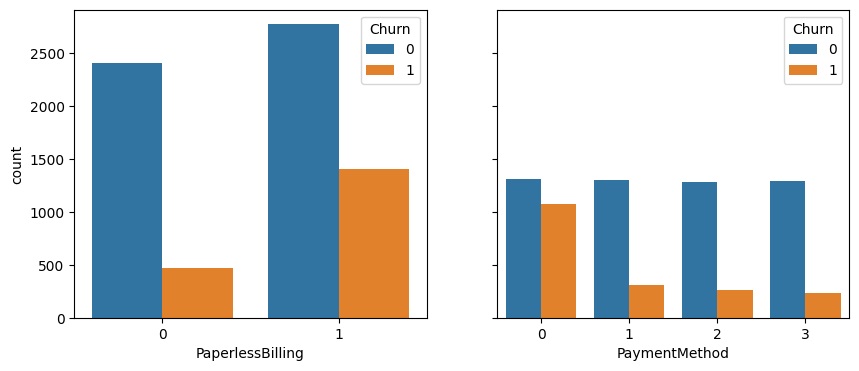

In [ ]:
# Does how a customer pays have to do with their churn?
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.countplot(x='PaperlessBilling', hue='Churn',
              data=data, ax=axes[0]);
sns.countplot(x='PaymentMethod', hue='Churn',
              data=data, ax=axes[1]);
# We can see that customers that use paperless billing are much more likely to churn (0 = don't have paperless billing). That seems backwards I would go check that data with the team.
# We can see that customers that have the 0 payment method (electronic check) are much more likely to churn. Let's discourage that option.

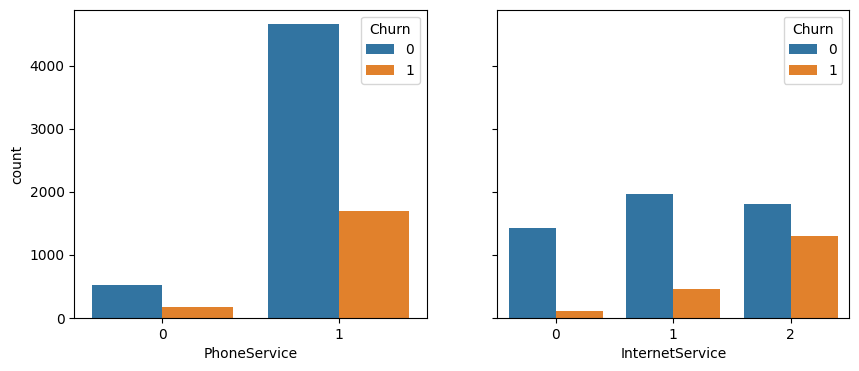

In [ ]:
# See if the other products they have from this company has to do with their churn.
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.countplot(x='PhoneService', hue='Churn',
              data=data, ax=axes[0]);
sns.countplot(x='InternetService', hue='Churn',
              data=data, ax=axes[1]);
# If they don't have Phone Service, they are more likely to churn.
# If they don't have Internet Service, they are more likely to churn. Those customers with the highest Internet Service are least likely to churn.
# Conclusion: This makes sense. Customers with other products from the company, and premium products, churn less.
# Offer customers these additional products, perhaps even at a deep discount, so they take them and are less likely to churn.

## 6:  Prepare the Data

## 7: Model Selection, Predictions, and Metrics

**Accuracy** is the proportion of true positives and negatives in the whole data set. It determines if a value is accurate compare it to the accepted value; the nearness of a calculation to the true value.

**AUC** (area under the ROC receiver operating characteristic curve) measures how true positive rate (recall) and false positive rate trade off, so in that sense it is already measuring something else. More importantly, AUC is not a function of threshold. It is an evaluation of the classifier as threshold varies over all possible values. It is in a sense a broader metric, testing the quality of the internal value that the classifier generates and then compares to a threshold.

**Accuracy vs AUC**: The accuracy depends on the threshold chosen, whereas the AUC considers all possible thresholds. Because of this it is often preferred as it provides a “broader” view of the performance of the classifier, but they still measure different things and as such using one or the other is problem-dependent.

## 8: Predict on New Cases

## 9: Tuning

##10: Levers

## The initial data showed that more tech support interactions reduced customer churn. Here are some ways to put that information into action:
To get customers interacting with tech support instead of cancelling:

1) Include this NPS data in the dataset for analysis, it is from the questionnaire in QuickBooks.

2) Make sure screens/flow to include links to Support during the Cancel process.

3) Offer users a way to get help even live chat right there instead of just a cancel option.

4) There could also be a 'Resolve Your Issue' link right next to the cancel option.